# Import libraries

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader


# Implement training dataset generator

In [2]:
#This class generates correlated memory vectors as decribed in (Benna, Fusi; 2021)
class CorrelatedPatterns():
    def __init__(self, 
                 L, #Length of each memory vector 
                 p, #Number of ancestors
                 k, #Number of children per ancestor
                 gamma): #Average overlap between child and ancestor. A value of one means each child is identical to its ancestor,
                        #while a value of zero means each child is completely different from its ancestor.
        self.L = L
        self.p = p
        self.k = k
        self.gamma = gamma
        
        #Create three arrays to store the ancestor vectors, the descendant (child) vectors, and the difference vectors
        self.ancestors = []
        self.descendants = []
        self.differences = []
        
        #For purposes of PyTorch dataset creation, we will create two new lists that do not themselves contain lists
        self.descendants_singlelist = []
        self.differences_singlelist = []
        
        for _ancestorIndex in range(p):
            
            #Each ancestor is initialized randomly
            ancestor = np.random.choice((0,1), size=(L))
            self.ancestors.append(np.array(ancestor))
            
            self.descendants.append([])
            #Initialize k descendants
            for _descendantIndex in range(k):
                descendant = torch.tensor([])
                for __i in range(len(ancestor)):
                    
                    #With probability 1-gamma, the descendant memory is corrupted at this bit. 
                    if(random.uniform(0,1) < 1-gamma):
                        descendant = torch.cat((descendant, torch.tensor([0 if random.uniform(0,1) < 0.5 else 1])))
                    else: #Otherwise, the ancestor's memory at this bit is copied to the descendant.
                        descendant = torch.cat((descendant, torch.tensor([ancestor[__i]])))
                
                #Save the memory
                self.descendants[_ancestorIndex].append(descendant.clone().detach())
                self.descendants_singlelist.append(descendant.clone().detach().reshape(1,-1))
            
            #Calculate the differences between the ancestor vectors and the child vectors
            self.differences.append([])
            for _descendantIndex in range(k):
                self.differences[_ancestorIndex].append(torch.tensor(self.ancestors[_ancestorIndex]) - self.descendants[_ancestorIndex][_descendantIndex])
                self.differences_singlelist.append((torch.tensor(self.ancestors[_ancestorIndex]) - self.descendants[_ancestorIndex][_descendantIndex]).reshape(1,-1))
                
        self.descendants_singlelist = torch.cat(self.descendants_singlelist)
        self.differences_singlelist = torch.cat(self.differences_singlelist)

#This subclass inherits the PyTorch Dataset class in order to create datasets of correlated memory.
class SensoryData(Dataset):
    def __init__(self, 
                 L,      #Length of each sample
                 p,      #Number of parents
                 k,      #Number of children per parent 
                 gamma   #Overlap between parent and children (1=identical, 0=no overlap)
                ):
        super().__init__()
        c = CorrelatedPatterns(L, p, k, gamma)
        memories = c.descendants_singlelist
        
        #Grab the memories generated by CorrelatedPatterns()
        self.data = memories
        self.x = memories
        self.y = memories
        self.n_samples = memories.shape[0]
    
    #Implement necessary helper functions
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Write models

In [3]:
# Implement autoencoder model

class Autoencoder(nn.Module):
    def __init__(self, 
                 n_inputs, #Number of input units
                 n_hiddens): #Number of hidden units
        super().__init__()
        
        self.n_inputs = n_inputs
        self.n_hiddens = n_hiddens
        
        #The encoder and decoder will be linear layers
        self.encoder = nn.Linear(n_inputs, n_hiddens)
        self.decoder = nn.Linear(n_hiddens, n_inputs)
        
    #Implement the forward pass
    def forward(self, X):
        self.encoded = F.relu(self.encoder(X))
        self.decoded = self.decoder(self.encoded)
        
        return self.decoded
    
#Implement the input encoder model
#This is an autoencoder without the hidden layer. This model cannot just learn the identity function, because noise 
#will be applied to input data during training.
class InputEncoder(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.n_inputs = n_inputs
        self.encoder = nn.Linear(n_inputs, n_inputs)
    
    def forward(self, X):
        self.encoded = self.encoder(X)
        
        return self.encoded

In [4]:
#Get best device if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def train(loader, #Dataloader
          model,  #Model to be trained
          loss_function, #Loss function
          optimizer, #Optimizer
          enforce_sparsity=True, #Whether to add a sparsity penalty or not (valid only for the autoencoder model) 
          desired_sparsity=0.05, #Desired sparsity level
          n_epochs=100 #number of epochs
         ):
    
    #Toggle to training mode
    model.train()
    
    
    for epoch in range(n_epochs):

        #Iterate through the DataLoader's batches
        for batch, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            
            #Get the model's prediction of the input
            predicted_y = model(X)
            
            #Calculate the loss
            loss = loss_function(predicted_y, y)
            
            #If the enforce_sparsity flag is True, this code runs.
            if(enforce_sparsity == True):
                
                #We will calculate the average hidden activity over every training example.
                total_hidden_activations = torch.zeros(loader.batch_size, model.n_hiddens)
                
                #Loop through every training example
                for _, (_X, _y) in enumerate(loader):
                    _X, _y = _X.to(device), _y.to(device)
                    
                    #Accumulate the hidden activity generated by the training example
                    total_hidden_activations += F.relu(model.encoder(_X))
                    
                #Take the average
                total_hidden_activations /= len(loader)
                
                #Calculate the sparsity penalty using Kullback-Leibler divergence. The motivation behind this algorithm is in a paper linked on the Github page.
                sparsity_penalty = torch.abs(torch.nn.functional.kl_div(total_hidden_activations, torch.Tensor([desired_sparsity]).repeat(total_hidden_activations.shape)))
                
                #Add the sparsity penalty to the overall loss
                loss += sparsity_penalty
            
            #Reset gradients
            optimizer.zero_grad()
            
            #Backpropagation
            loss.backward()
            
            #Update the optimizer
            optimizer.step()

In [6]:
#Add noise to a memory vector
def mutate(data, #An array of memories
           gamma #The level of overlap between the noised vectors and the old vectors. A value of 0 results in the most noise.
          ):
    
    #Create a new array of memory vectors in the shape of the old array
    newdata = torch.zeros_like(data)
    
    #Iterate through the memories
    for row in range(data.shape[0]):     #Each row is a memory
        for col in range(data.shape[1]): #Each column is an entry in that memory vector
            
            #Add noise based on the gamma parameter
            if random.uniform(0,1) > gamma:
                newdata[row][col] = 0 if random.uniform(0,1) < 0.5 else 1
            else:
                newdata[row][col] = data[row][col]
    return newdata


#Test how many memories can be reconstructed after training
def evaluate(loader,  #dataloader of trained data
             model, #model
             input_length): #memory length 
    
    #Switch to evaluation mode
    model.eval()
    
    #Count the number of recalled memories
    correctly_recalled_memories = 0
    
    #Turn off gradient calculations for speed
    with torch.no_grad():
        
        #Iterate through each training example
        for batch, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            #Add noise to the input memory
            X = mutate(X, 0.8) 
            
            #Get prediction
            predicted_y = model(X) 
            
            #Calculate absolute error
            error = torch.abs(y - predicted_y)
            
            #Does the reconstructed memory sufficiently match the original memory?
            matching_count = torch.count_nonzero(error < 0.5)
            if(matching_count/input_length >= 0.9): #If so, increment the count of successfully reconstructed memories.
                correctly_recalled_memories += 1
            
    return correctly_recalled_memories

In [7]:
memory_len = 300 #Set the length of each memory vector to 300, as in the paper.

#Record the reconstruction statistics for the sparse autoencoder and input encoder
sparse_autoencoder_results = [] 
input_encoder_results = []


k = 20 #Fix the number of children per parent 

#Loop over the number of parent memories to create
for experimentNum in range(25)
    
    #Generate a dataset of correlated memories
    data = SensoryData(memory_len, 
                       experimentNum+1, #Number of parents
                       k, #Number of children per parent
                       0.6) #Each child memory will, on average, have a 60% overlap with its parent memory
    dataloader = DataLoader(dataset=data, batch_size=5, shuffle=True)     #Initialize the training dataloader
    eval_dataloader = DataLoader(dataset=data, batch_size=1, shuffle=True) #Initialize the evaluation dataloader. We want to evaulate each memory by itself, thus batch_size=1
    
    #Initialize models
    sparse_autoencoder = Autoencoder(memory_len, 2*memory_len).to(device)
    input_encoder = InputEncoder(memory_len).to(device)
    
    #Initialize loss function
    loss_function = nn.MSELoss()
                           
    #Initialize optimizers
    sparse_optimizer = torch.optim.Adam(sparse_autoencoder.parameters(), lr=1e-3)
    input_optimizer = torch.optim.Adam(input_encoder.parameters(), lr=1e-3)

    #Train the models                      
    train(dataloader, sparse_autoencoder, loss_function, sparse_optimizer, enforce_sparsity=True, desired_sparsity=0.075)
    train(dataloader, input_encoder, loss_function, input_optimizer, enforce_sparsity=False)

    #Validate the models and record the results
    sparse_autoencoder_recalled = evaluate(eval_dataloader, sparse_autoencoder, memory_len)
    input_encoder_recalled = evaluate(eval_dataloader, input_encoder, memory_len)
    
    #Append results      
    sparse_autoencoder_results.append((k*(experimentNum+1), sparse_autoencoder_recalled))
    input_encoder_results.append((k*(experimentNum+1), input_encoder_recalled))

    print(f"Sparse autoencoder performance: Given {k*(experimentNum+1)} memory vectors, {sparse_autoencoder_recalled} were recalled.")
    print(f"Input encoder performance: Given {k*(experimentNum+1)} memory vectors, {input_encoder_recalled} were recalled.")


SyntaxError: invalid syntax (Temp/ipykernel_13288/4211594240.py, line 14)

Text(0.5, 1.0, 'Hidden layer activations with sparse loss enabled')

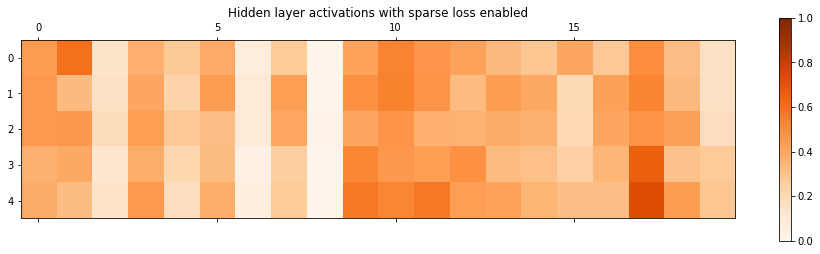

In [64]:
plt.matshow(sparse_avg_activity, cmap='Oranges', vmin=0, vmax=1)
plt.colorbar()
plt.title("Hidden layer activations with sparse loss enabled")

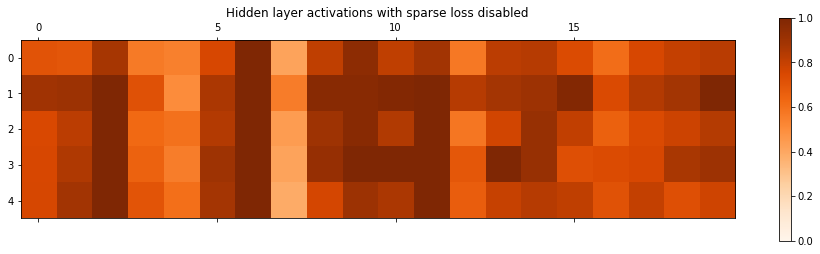

In [65]:
plt.matshow(regular_avg_activity, cmap='Oranges', vmin=0,vmax=1)
plt.title("Hidden layer activations with sparse loss disabled")
plt.colorbar()